In [23]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions

In [38]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14613 samples in total but only 492 cases of fraud


### Feature Scaling

In [39]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.36138071e-01  1.08747932e-01 -2.31636452e-01  1.43066709e-01
 -8.71082980e-02 -5.13922332e-02 -1.64526465e-01  7.89883117e-03
 -9.76343425e-02 -1.88949167e-01  1.24586302e-01 -1.87390859e-01
 -1.01443419e-02 -2.29775306e-01  7.81853052e-03 -1.31768137e-01
 -2.22835738e-01 -8.47656214e-02  2.94615613e-02  1.32879422e-02
  3.18184249e-02  1.20779615e-02 -5.21694121e-03 -6.69735803e-03
 -3.74077645e-03  1.01309416e-03  5.11590009e-03 -1.09001717e-03
  9.11537166e+01]
[5.84373454e+00 3.85842725e+00 5.38963903e+00 2.86785646e+00
 3.09604938e+00 1.88607838e+00 4.11254513e+00 2.86731019e+00
 1.53335185e+00 2.90503745e+00 1.66953850e+00 2.84290350e+00
 9.88577657e-01 2.95215138e+00 8.32541491e-01 1.75163967e+00
 3.63238363e+00 1.11950579e+00 7.37049834e-01 7.38136345e-01
 1.08624144e+00 6.02125068e-01 4.17537170e-01 3.67978125e-01
 2.84038369e-01 2.25896809e-01 2.19285145e-01 8.80268571e-02
 8.66798281e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [40]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 5.89338261e-16  4.03293471e-16  9.97119007e-16 -5.79879370e-16
 -4.76211450e-16 -1.81428357e-17 -1.57786829e-16 -2.39646119e-16
  3.56482410e-16  1.30526990e-15  1.23003564e-15  5.80259245e-16
 -2.09903796e-16  6.21574463e-16 -3.82640610e-16 -4.71045148e-19
 -8.53190022e-17  4.85434818e-16 -6.33631700e-18  2.04657721e-17
 -1.95960480e-16 -3.43255158e-17  1.72477550e-17 -2.96302593e-18
 -3.45321679e-16  7.94698750e-17 -1.42871032e-17  1.57553206e-17
  6.48917684e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.06937359  0.24749113  1.23742903 -0.93573151 -1.16942246  0.15833178
  1.110692    1.14736893  1.15693907]


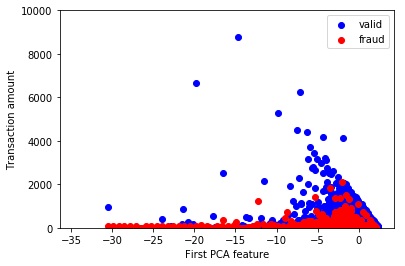

In [41]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [42]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [45]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [46]:
train_binary_SVM(data);

Fold 0
[[2816    9]
 [  20   79]]
Fold 1
[[2810   14]
 [  19   80]]
Fold 2
[[2815    9]
 [  24   74]]
Fold 3
[[2815    9]
 [  23   75]]
Fold 4
[[2816    8]
 [  19   79]]
Final Confusion Matrix
[[2814.4    9.8]
 [  21.    77.4]]
False negatives (valid): 0.0034700092061468735
False positives (fraud): 0.21341463414634146


#### Linear SVM with Scaling

In [47]:
train_binary_SVM(data, scale=True);

Fold 0
[[2816    9]
 [  13   86]]
Fold 1
[[2820    4]
 [  16   83]]
Fold 2
[[2816    8]
 [  20   78]]
Fold 3
[[2817    7]
 [  17   81]]
Fold 4
[[2813   11]
 [  16   82]]
Final Confusion Matrix
[[2816.4    7.8]
 [  16.4   82. ]]
False negatives (valid): 0.002761844062035266
False positives (fraud): 0.16666666666666663


#### Linear SVM with Scaling and Class Weights

In [48]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2673  152]
 [   5   94]]
Fold 1
[[2690  134]
 [   7   92]]
Fold 2
[[2723  101]
 [  11   87]]
Fold 3
[[2691  133]
 [   8   90]]
Fold 4
[[2688  136]
 [   7   91]]
Final Confusion Matrix
[[2693.   131.2]
 [   7.6   90.8]]
False negatives (valid): 0.046455633453721404
False positives (fraud): 0.07723577235772358


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [49]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2823    2]
 [  20   79]]
Fold 1
[[2821    3]
 [  21   78]]
Fold 2
[[2822    2]
 [  23   75]]
Fold 3
[[2823    1]
 [  21   77]]
Fold 4
[[2823    1]
 [  18   80]]
Final Confusion Matrix
[[2.8224e+03 1.8000e+00]
 [2.0600e+01 7.7800e+01]]
False negatives (valid): 0.0006373486297004461
False positives (fraud): 0.20934959349593496


In [50]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2818    7]
 [  44   55]]
Fold 1
[[2807   17]
 [  41   58]]
Fold 2
[[2805   19]
 [  45   53]]
Fold 3
[[2817    7]
 [  53   45]]
Fold 4
[[2817    7]
 [  50   48]]
Final Confusion Matrix
[[2812.8   11.4]
 [  46.6   51.8]]
False negatives (valid): 0.004036541321436158
False positives (fraud): 0.4735772357723577


#### Polynomial Kernel with Scaling and Class Weights

In [51]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2822    3]
 [  14   85]]
Fold 1
[[2821    3]
 [  15   84]]
Fold 2
[[2821    3]
 [  24   74]]
Fold 3
[[2818    6]
 [  21   77]]
Fold 4
[[2819    5]
 [  21   77]]
Final Confusion Matrix
[[2820.2    4. ]
 [  19.    79.4]]
False negatives (valid): 0.0014163302882232137
False positives (fraud): 0.19308943089430894


In [52]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2807   18]
 [  10   89]]
Fold 1
[[2804   20]
 [  13   86]]
Fold 2
[[2812   12]
 [  19   79]]
Fold 3
[[2801   23]
 [  18   80]]
Fold 4
[[2806   18]
 [  14   84]]
Final Confusion Matrix
[[2806.    18.2]
 [  14.8   83.6]]
False negatives (valid): 0.006444302811415622
False positives (fraud): 0.15040650406504066


### Logistic Regression

In [53]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [54]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_logistic_regression(data, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[2822    3]
 [  19   80]]
Area under curve: 0.9530955573433448
Fold 1
[[2823    1]
 [  19   80]]
Area under curve: 0.9617062981085645


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2821    3]
 [  23   75]]
Area under curve: 0.9330230675839741
Fold 3
[[2822    2]
 [  19   79]]
Area under curve: 0.973579233393074
Fold 4
[[2822    2]
 [  16   82]]
Area under curve: 0.9583887379314332
Final Confusion Matrix
[[2.822e+03 2.200e+00]
 [1.920e+01 7.920e+01]]


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: not enough values to unpack (expected 3, got 2)

### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)

# kNN

In [43]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

In [44]:
for k in [5, 7, 9, 11]:
    conf = train_KNN(data, k)
    print('Confusion Matrix:')
    print(conf)
    print()

Fold 0
[[2824    1]
 [  22   77]]
Fold 1
[[2823    1]
 [  26   73]]
Fold 2
[[2821    3]
 [  33   65]]
Fold 3
[[2822    2]
 [  28   70]]
Fold 4
[[2823    1]
 [  24   74]]
Final Confusion Matrix
[[2.8226e+03 1.6000e+00]
 [2.6600e+01 7.1800e+01]]
False negatives (valid): 0.0005665321152892855
False positives (fraud): 0.2703252032520325
Confusion Matrix:
[[2.8226e+03 1.6000e+00]
 [2.6600e+01 7.1800e+01]]

Fold 0
[[2824    1]
 [  25   74]]
Fold 1
[[2823    1]
 [  29   70]]
Fold 2
[[2821    3]
 [  40   58]]
Fold 3
[[2823    1]
 [  31   67]]
Fold 4
[[2823    1]
 [  31   67]]
Final Confusion Matrix
[[2.8228e+03 1.4000e+00]
 [3.1200e+01 6.7200e+01]]
False negatives (valid): 0.0004957156008781247
False positives (fraud): 0.31707317073170727
Confusion Matrix:
[[2.8228e+03 1.4000e+00]
 [3.1200e+01 6.7200e+01]]

Fold 0
[[2824    1]
 [  27   72]]
Fold 1
[[2823    1]
 [  31   68]]
Fold 2
[[2821    3]
 [  40   58]]
Fold 3
[[2823    1]
 [  34   64]]
Fold 4
[[2823    1]
 [  31   67]]
Final Confusion Mat